# Tutorial 4 FANTASY
### Goal: Run the tutorial notebook for a new object

This notebook is almost an exact copy of the offficial Fantasy tutorial notebook just without most coments so it's easier to navigate. It is also missing the example host fit for a host dominated AGN. Additionaly, I added axes to the first plot and another line to the final plot. I also removed two redundant lines. There are a lot of changes to the model itself.

#### The object picked for this fitting was randomly selected from the type 1 AGN we had in our data set from Tutorial 1.
I tried to fit for an object taken from Lyke et al. 2020 first but I encountered a lot of issues. I imagine the reason was a very different redsift of the objects so the part of the spectrum observed was significantly different and it would require a bunch of chages to the model. Simmilar issue was encountered anyway but things seemed to work at least a little bit better with the current object. 


In [1]:
#Before starting, we call some of the standard python packages, such as matplotlib, pandas, numpy, etc. 
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

import numpy as np
import pandas as pd

import glob

In [2]:
# Below command import the above mentioned reading commands
from fantasy_agn.tools import read_sdss, read_text, read_gama_fits

# Below command import the necessary commands, which will be described later
from fantasy_agn.models import create_input_folder

from fantasy_agn.models import create_feii_model, create_model, create_tied_model, continuum, create_line, create_fixed_model

In [18]:
s=read_sdss('spec-0268-51633-0235.fits')

In [19]:
s.DeRedden()
s.CorRed()
s.fit_host_sdss(mask_host=True, custom=False)

Host contribution is negliglable


Here in the original code, first the ost is fitted, then the original spectrum is restored and then a host is fitted again, which I've ommitted as it is redundant. 

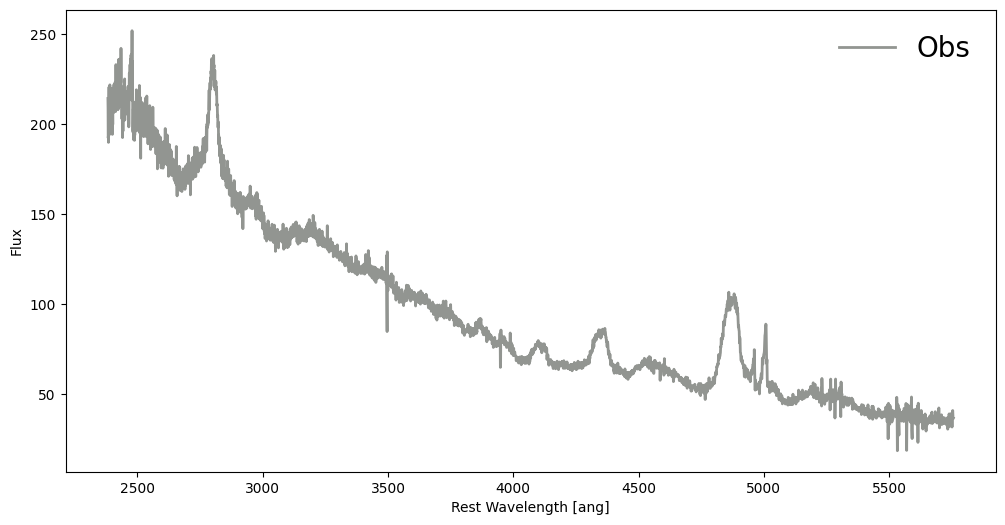

In [20]:
plt.style.context(['nature', 'notebook'])
plt.figure(figsize=(12,6))
plt.plot(s.wave, s.flux, color="#929591", label='Obs', lw=2)
plt.xlabel('Rest Wavelength [ang]')
plt.ylabel('Flux')
plt.legend(loc='upper right',  prop={'size': 20}, frameon=False, ncol=2)


In [6]:
create_input_folder(xmin=2500,xmax=5000, path_to_folder='liness_new/')

Directory  liness_new/  already exists


In [7]:
# Crop function cuts the spectrum in a set wavelength range, e.g., if you want to fit just 
# one emission line or a certain wavelength range

s.crop(2500, 5500)
print(s.wave) # simple examine of the wavelength range

[2500.5117 2501.087  2501.6636 ... 5497.084  5498.351  5499.6157]


In [8]:
cont = continuum(s)
broad_h = create_fixed_model(['hydrogen.csv'], name='br')
broad = create_model(['broad.csv'])
he = create_fixed_model(['helium.csv'], name='he')
narrow = create_tied_model(name='OIII5007',files=['narrow_basic.csv','hydrogen.csv'],prefix='nr', fwhm=1000,min_offset=0, max_offset=300, min_fwhm=900, max_fwhm=1200,fix_oiii_ratio=True, position=5006.803341, included=True,min_amplitude=0.2)
fe = create_feii_model(name='feii')

Reaching a conclusion on these parameters was really tough. Firstly, the parameters in the example would of course not work for this object. They didn't even produce a fit. I assume motly because the continuum break would be outside of the recorded spectrum for this object. Deciding where to put the continuum break in this case took a few triels and errors and was completely abandoned at the end. 

For the lines, I did not know how to set all the parameters appropriately, which is why at first I decided to use only the create_model function where nothing is fixed. Slowly, one by one, I started reintroducing some constraints (e.g. making the broad lines of fixed width). One big issue I encountered was the big line on the left of the plot. Since nothing I tried could model it, I checked the spectrum in SDSS and there it says this is a Mg II 2799 line. I did not know where, if at all, this line is included in the FANTASY code so I added both 'broad.csv' lines and 'narrow_plus.csv' lines. I still don't know where I could check what lines are included in those files? But at the end of the day the 'broad.csv' file seemed to help with modeling this line. When I discovered 'broad.csv' models the line just fine, I reverted back to 'narrow_basic.csv'. I kept having issues with the [OIII] lines so I added back the parameters for narrow lines from the original notebook (create_tied_model).

Overall, whenever possible, I decided to let the code make decisions instead of me (Not necessarily the best scientific approach in real life). At the end of the day, leaving the code with less constraints and a broad range for the parameters makes it run way slower but still produces not-too-bad results which means FANTASY is more or less fool proof and can be reasonably used even by people that don't know what they are doing. :)

In [9]:
model = cont + broad + narrow + fe + he + broad_h
s.fit(model, ntrial = 2)

stati 287527.2054773408
1 iter stat:  382.26907953932823
2 iter stat:  190.20349664210153


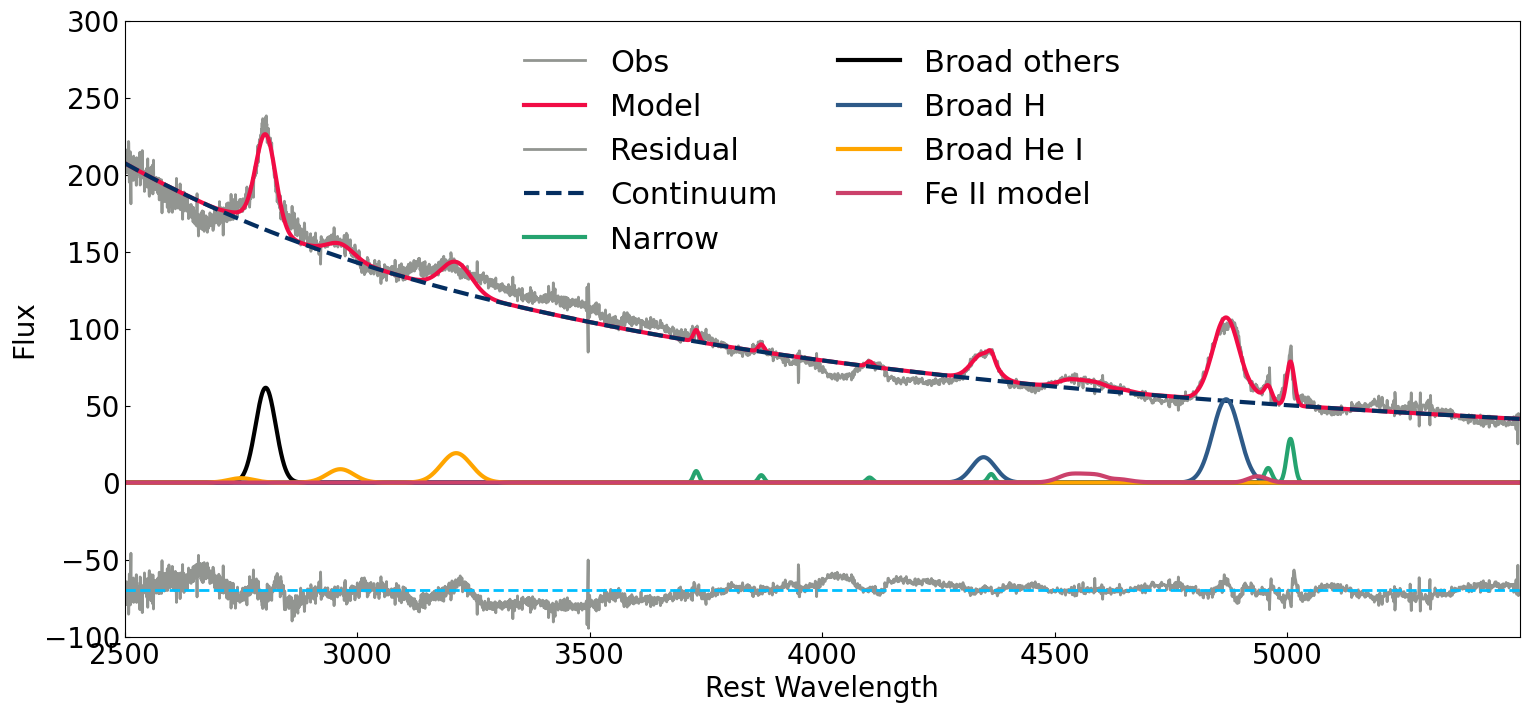

In [16]:
plt.style.context(['nature', 'notebook'])
plt.figure(figsize = (18,8))
plt.plot(s.wave, s.flux, color = "#929591", label = 'Obs', lw = 2)
plt.plot(s.wave, model(s.wave), color = "#F10C45", label = 'Model',lw = 3)
plt.plot(s.wave, model(s.wave) - s.flux - 70, '-', color = "#929591", label = 'Residual', lw = 2)
plt.axhline(y = -70, color = 'deepskyblue', linestyle = '--', lw = 2)

plt.plot(s.wave, cont(s.wave), '--', color = "#042E60", label = 'Continuum', lw = 3)
plt.plot(s.wave, narrow(s.wave),label = 'Narrow', color = "#25A36F", lw = 3)
plt.plot(s.wave, broad(s.wave), label = 'Broad others', lw = 3, color = 'black')
plt.plot(s.wave, broad_h(s.wave), label = 'Broad H', lw = 3, color = "#2E5A88")
plt.plot(s.wave, he(s.wave), label = 'Broad He I', lw = 3, color = "orange")
plt.plot(s.wave, fe(s.wave), '-', color = "#CB416B",label = 'Fe II model', lw = 3)

plt.xlabel('Rest Wavelength',fontsize = 20)
plt.ylabel('Flux',fontsize = 20)
plt.xlim(2500, 5500)
plt.ylim(-100,300)
plt.tick_params(which = 'both', direction = "in")
plt.yticks(fontsize = 20)
plt.xticks(np.arange(2500, 5500, step = 500),fontsize = 20)
plt.legend(loc = 'upper center',  prop = {'size': 22}, frameon = False, ncol = 2)

plt.savefig('Final_fit.pdf')

In [17]:
print(s.gres.format())
s.save_json()

Method                = levmar
Statistic             = chi2
Initial fit statistic = 16634
Final fit statistic   = 16443.8 at function evaluation 889
Data points           = 3424
Degrees of freedom    = 3381
Probability [Q-value] = 0
Reduced statistic     = 4.86358
Change in statistic   = 190.203
   brokenpowerlaw.refer   5618.46      +/- 0           
   brokenpowerlaw.ampl   39.5952      +/- 0.0660495   
   brokenpowerlaw.index1   -2.04482     +/- 0.00311979  
   brokenpowerlaw.index2   -0.0534055   +/- 0           
   _MgII_2800.ampl   61.5801      +/- 0.771813    
   _MgII_2800.offs_kms   316.346      +/- 36.9666     
   _MgII_2800.fwhm   5441.82      +/- 85.2082     
   nr_OIII5007.ampl   28.4372      +/- 0.675602    
   nr_OIII5007.offs_kms   0.0354818    +/- 11.3938     
   nr_OIII5007.fwhm   1149.38      +/- 27.3939     
   nr_NII6584.ampl   5.13255      +/- 0           
   nr_[OII]_3726.ampl   0.0354818    +/- 1.88134     
   nr_[OII]_3728.ampl   7.4538       +/- 1.87252     
  

In [22]:
model

<BinaryOpModel model instance '(((((brokenpowerlaw + (0.0 + _MgII_2800)) + (((((((((((nr_OIII5007 + nr_OIII4958) + nr_NII6584) + nr_NIII6548) + nr_[OII]_3726) + nr_[OII]_3728) + nr_[NeIII]_3868) + nr_[OIII]_4363) + nr_Heps_3970) + nr_Hd_4101) + nr_Hg_4340) + nr_Hb_4861)) + feii) + he) + br)'>

## Here, istead of the $H{\alpha}$ line, I am calculating the total flux of the Magnesium line that made this model so hard to produce. 

In [21]:
# Integrate total FeII model,
flux_feII=np.sum(fe(s.wave))
print("FeII total flux=",flux_feII)

# Mask the wavelength range of interess (e.g. Mg line) and integrate broad component.
x = s.wave
mask_mg = (x > 2600) & (x < 2800)
Mg_broad=np.sum(broad(s.wave)[mask_mg])
print("Mg_broad=", Mg_broad)

FeII total flux= 917.4341
Mg_broad= 2332.7527
